In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF 
from statsmodels.stats.anova import anova_lm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize , poly) 
from scipy import stats

import matplotlib.pyplot as plt
import statsmodels.formula.api as smf  # Statsmodels is a Python module for statistics
import statsmodels.api as sm
import seaborn as sns
sns.set()

<h3>Question 8</h3>

<h4> part a)</h4>

In [114]:
#Implementing linear regression from scratch, using matrix form
#beta coeffcieints derived from the setting d(SSE)/dB where SSE = (y-X*B)^T*(y-X*B)
#beta = (X^T*X)^-1*(X^T*y)
#var(B) driven by error term in beta = (X^T*X)^-1*(X^T*y) where y=(XB+error)
#var(B) = sigma^2*(X^T*X)^-1
#SE is the squre_root of the diagonal elements of the variance
auto = load_data("Auto")
df = auto.reset_index()

def linear_model(x,y):
    beta = np.linalg.inv(X.T @ X) @ (X.T @ y)
    return beta

def predict(X, coefficients):
    #coefficients = linear_model(x,y)
    return (X @ coefficients)

X_ = pd.DataFrame({'intercept': np.ones(auto.shape[0]),
                  'horsepower': auto['horsepower']})

y = auto['mpg'].values
X = X_.values

coefficients = linear_model(X,y)
y_pred = predict(X, coefficients)

#Summary statistics
sigma_squared = np.sum((y_pred - y)**2)/(len(y)-len(coefficients))
variance = sigma_squared * (np.linalg.inv(X.T @ X)).diagonal()
standard_error = np.sqrt(variance)
t_statistic = coefficients / standard_error
p_values = 2*(1 - stats.t.cdf(X.shape[0], np.abs(t_statistic)))

results = pd.DataFrame({'feature': X_.columns,
                        'coefficient': coefficients,
                        'std. error': standard_error,
                        't-statistic': t_statistic,
                        'P-value': p_values})
results

,feature,coefficient,std. error,t-statistic,P-value
0,intercept,39.935861,0.717499,55.659841,0.0
1,horsepower,-0.157845,0.006446,-24.489135,0.0


In [115]:
# using statsmodel ols for linear regression and compare with results created above 
X = auto['horsepower']
X = sm.add_constant(X)     # add bias constant
y = auto['mpg']

results = sm.OLS(y, X).fit()
predictions = results.predict(X)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           7.03e-81
Time:                        20:51:38   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.0

In [116]:
X2 = np.array([1, 98])
print("i) Relationship between predictor and response exists - low p value\nii) Each unit increase in horsepower lowers mpg by 0.1578\niii) Negative relationshipiv) mpg = 39.94 * -0.1578(98) =", predict(X2, coefficients))
conf_interval_95 = results.conf_int(alpha=0.05)
prediction_conf_interval_95 = [predict(conf_interval_95[0], X2), predict(conf_interval_95[1], X2)]
print('95% CI MPG for 98 horsepower:', prediction_conf_interval_95)

i) Relationship between predictor and response exists - low p value
ii) Each unit increase in horsepower lowers mpg by 0.1578
iii) Negative relationshipiv) mpg = 39.94 * -0.1578(98) = 24.467077152512434
95% CI MPG for 98 horsepower: [21.814544959722653, 27.119609345302212]


<h4>Part b) and c)</h4>

In [117]:
print("Strong non-linearity seen from Residual Plot for Linear Fit")
print("Q-Q Plot shows normality holds")
print("Some high leverage points indicate a difference of normality. These outliers may be having an effect on the coefficients")
print("Cook's distance plot shows no obervation is near or close to 1. However, one observation stands out among others - may have impact")

Strong non-linearity seen from Residual Plot for Linear Fit
Q-Q Plot shows normality holds
Some high leverage points indicate a difference of normality. These outliers may be having an effect on the coefficients
Cook's distance plot shows no obervation is near or close to 1. However, one observation stands out among others - may have impact


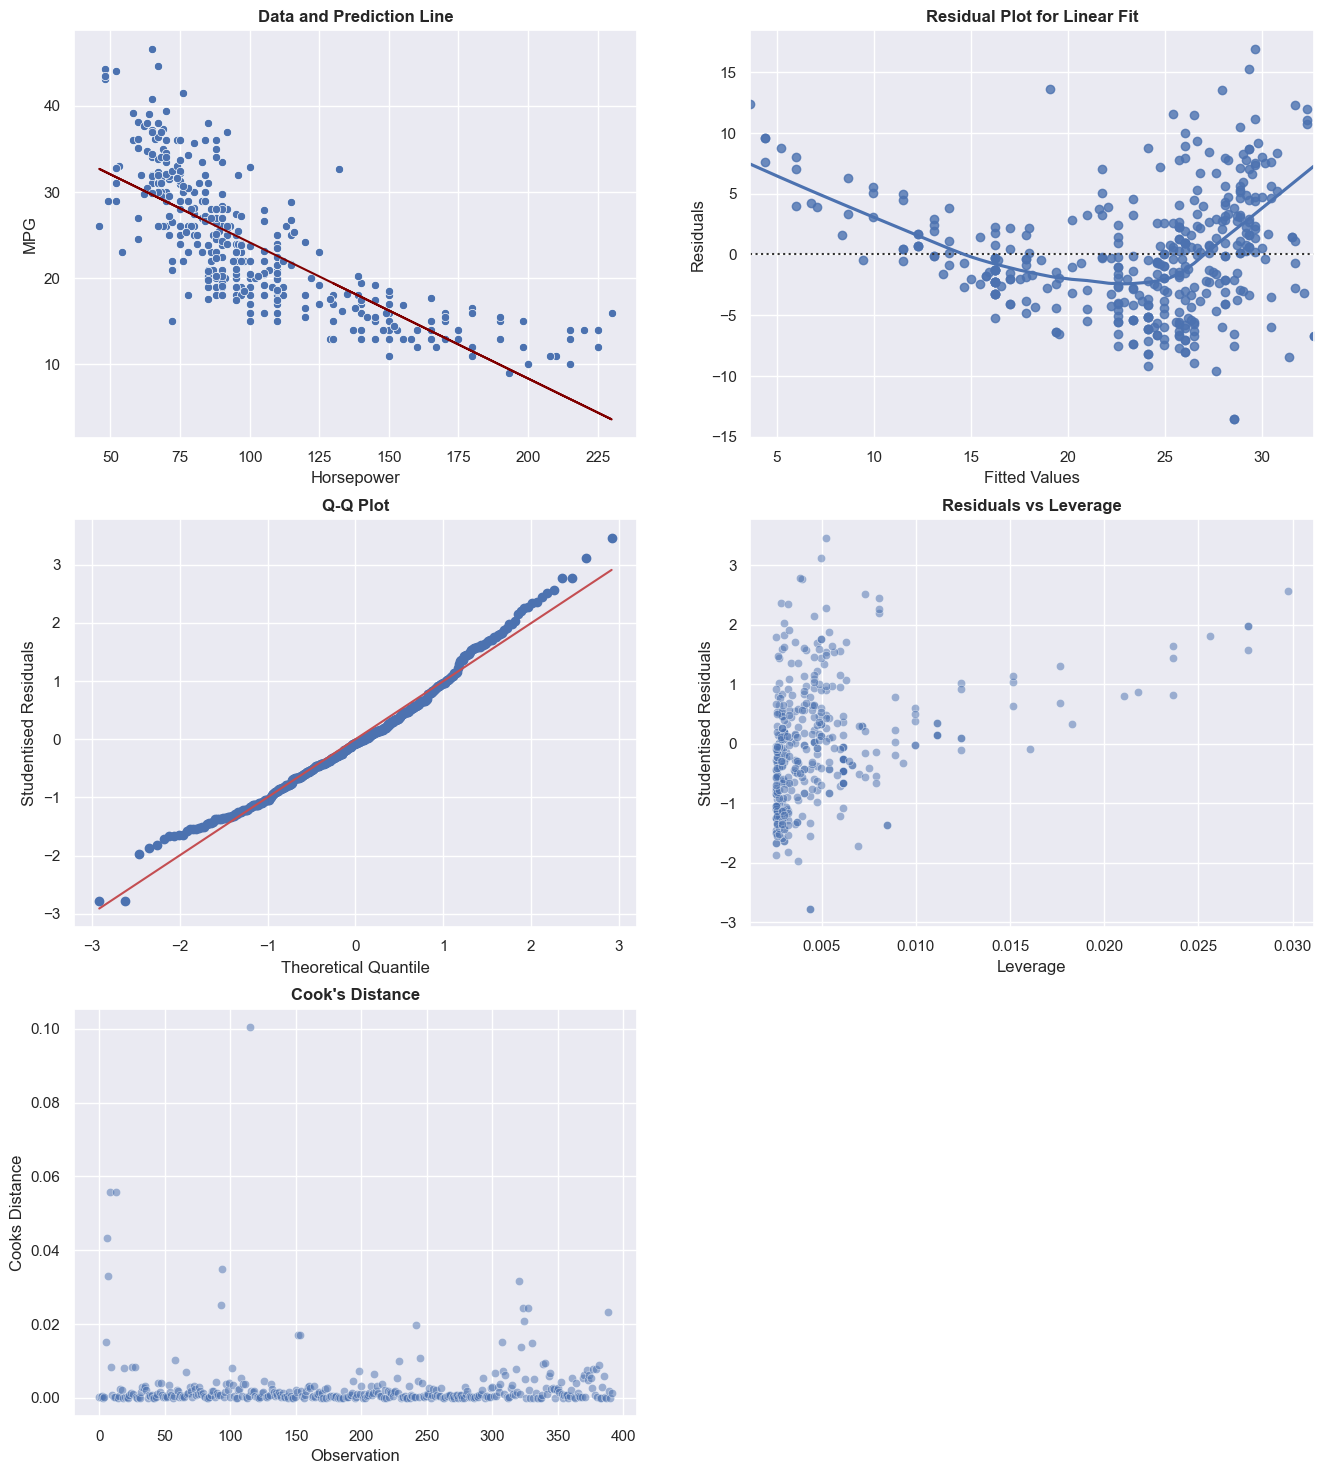

In [118]:
#Diagnostic Plots
def diagnostic_plots(x, y, df):
    plt.figure(1, figsize=(16, 18))
    X = df[x].values
    X = sm.add_constant(X) 
    y = df[y].values
    results = sm.OLS(y, X).fit()

    plot_number = 321

    if len(x) == 1:
        plt.subplot(plot_number)
        plot_number += 1
        ax = sns.scatterplot(x=x[0], y=y, data=df)
        predictions = results.predict(X)
        ax.plot(df['horsepower'], results.fittedvalues, color='maroon')
        plt.xlabel('Horsepower')
        plt.ylabel('MPG')
        plt.title('Data and Prediction Line', fontweight='bold')
    
    plt.subplot(plot_number)
    plot_number += 1
    ax = sns.residplot(x=results.fittedvalues, y=results.resid, lowess=True)
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot for Linear Fit', fontweight='bold')
    
    plt.subplot(plot_number)
    plot_number += 1
    ax = stats.probplot(results.get_influence().resid_studentized_internal, dist='norm', plot=plt)
    plt.xlabel('Theoretical Quantile')
    plt.ylabel('Studentised Residuals')
    plt.title('Q-Q Plot', fontweight='bold')
    
    plt.subplot(plot_number)
    plot_number += 1
    hat_matrix = results.get_influence().hat_matrix_diag
    normalized_residuals = results.get_influence().resid_studentized_internal
    normalized_residuals_abs_sqrt = np.sqrt(np.abs(normalized_residuals))
    ax = sns.scatterplot(x=hat_matrix, y=normalized_residuals, alpha=0.5)
    plt.xlabel('Leverage')
    plt.ylabel('Studentised Residuals')
    plt.title('Residuals vs Leverage', fontweight='bold')
    
    plt.subplot(plot_number)
    cooks = results.get_influence().cooks_distance[0]
    observation = [i for i in range(len(results.get_influence().cooks_distance[0]))]
    ax = sns.scatterplot(x=observation, y=cooks, alpha=0.5)
    plt.xlabel('Observation')
    plt.ylabel('Cooks Distance')
    plt.title('Cook\'s Distance', fontweight='bold')
diagnostic_plots(x=['horsepower'], y='mpg', df=auto)

<h3>Question 9</h3>

<h4>Part a)</h4>

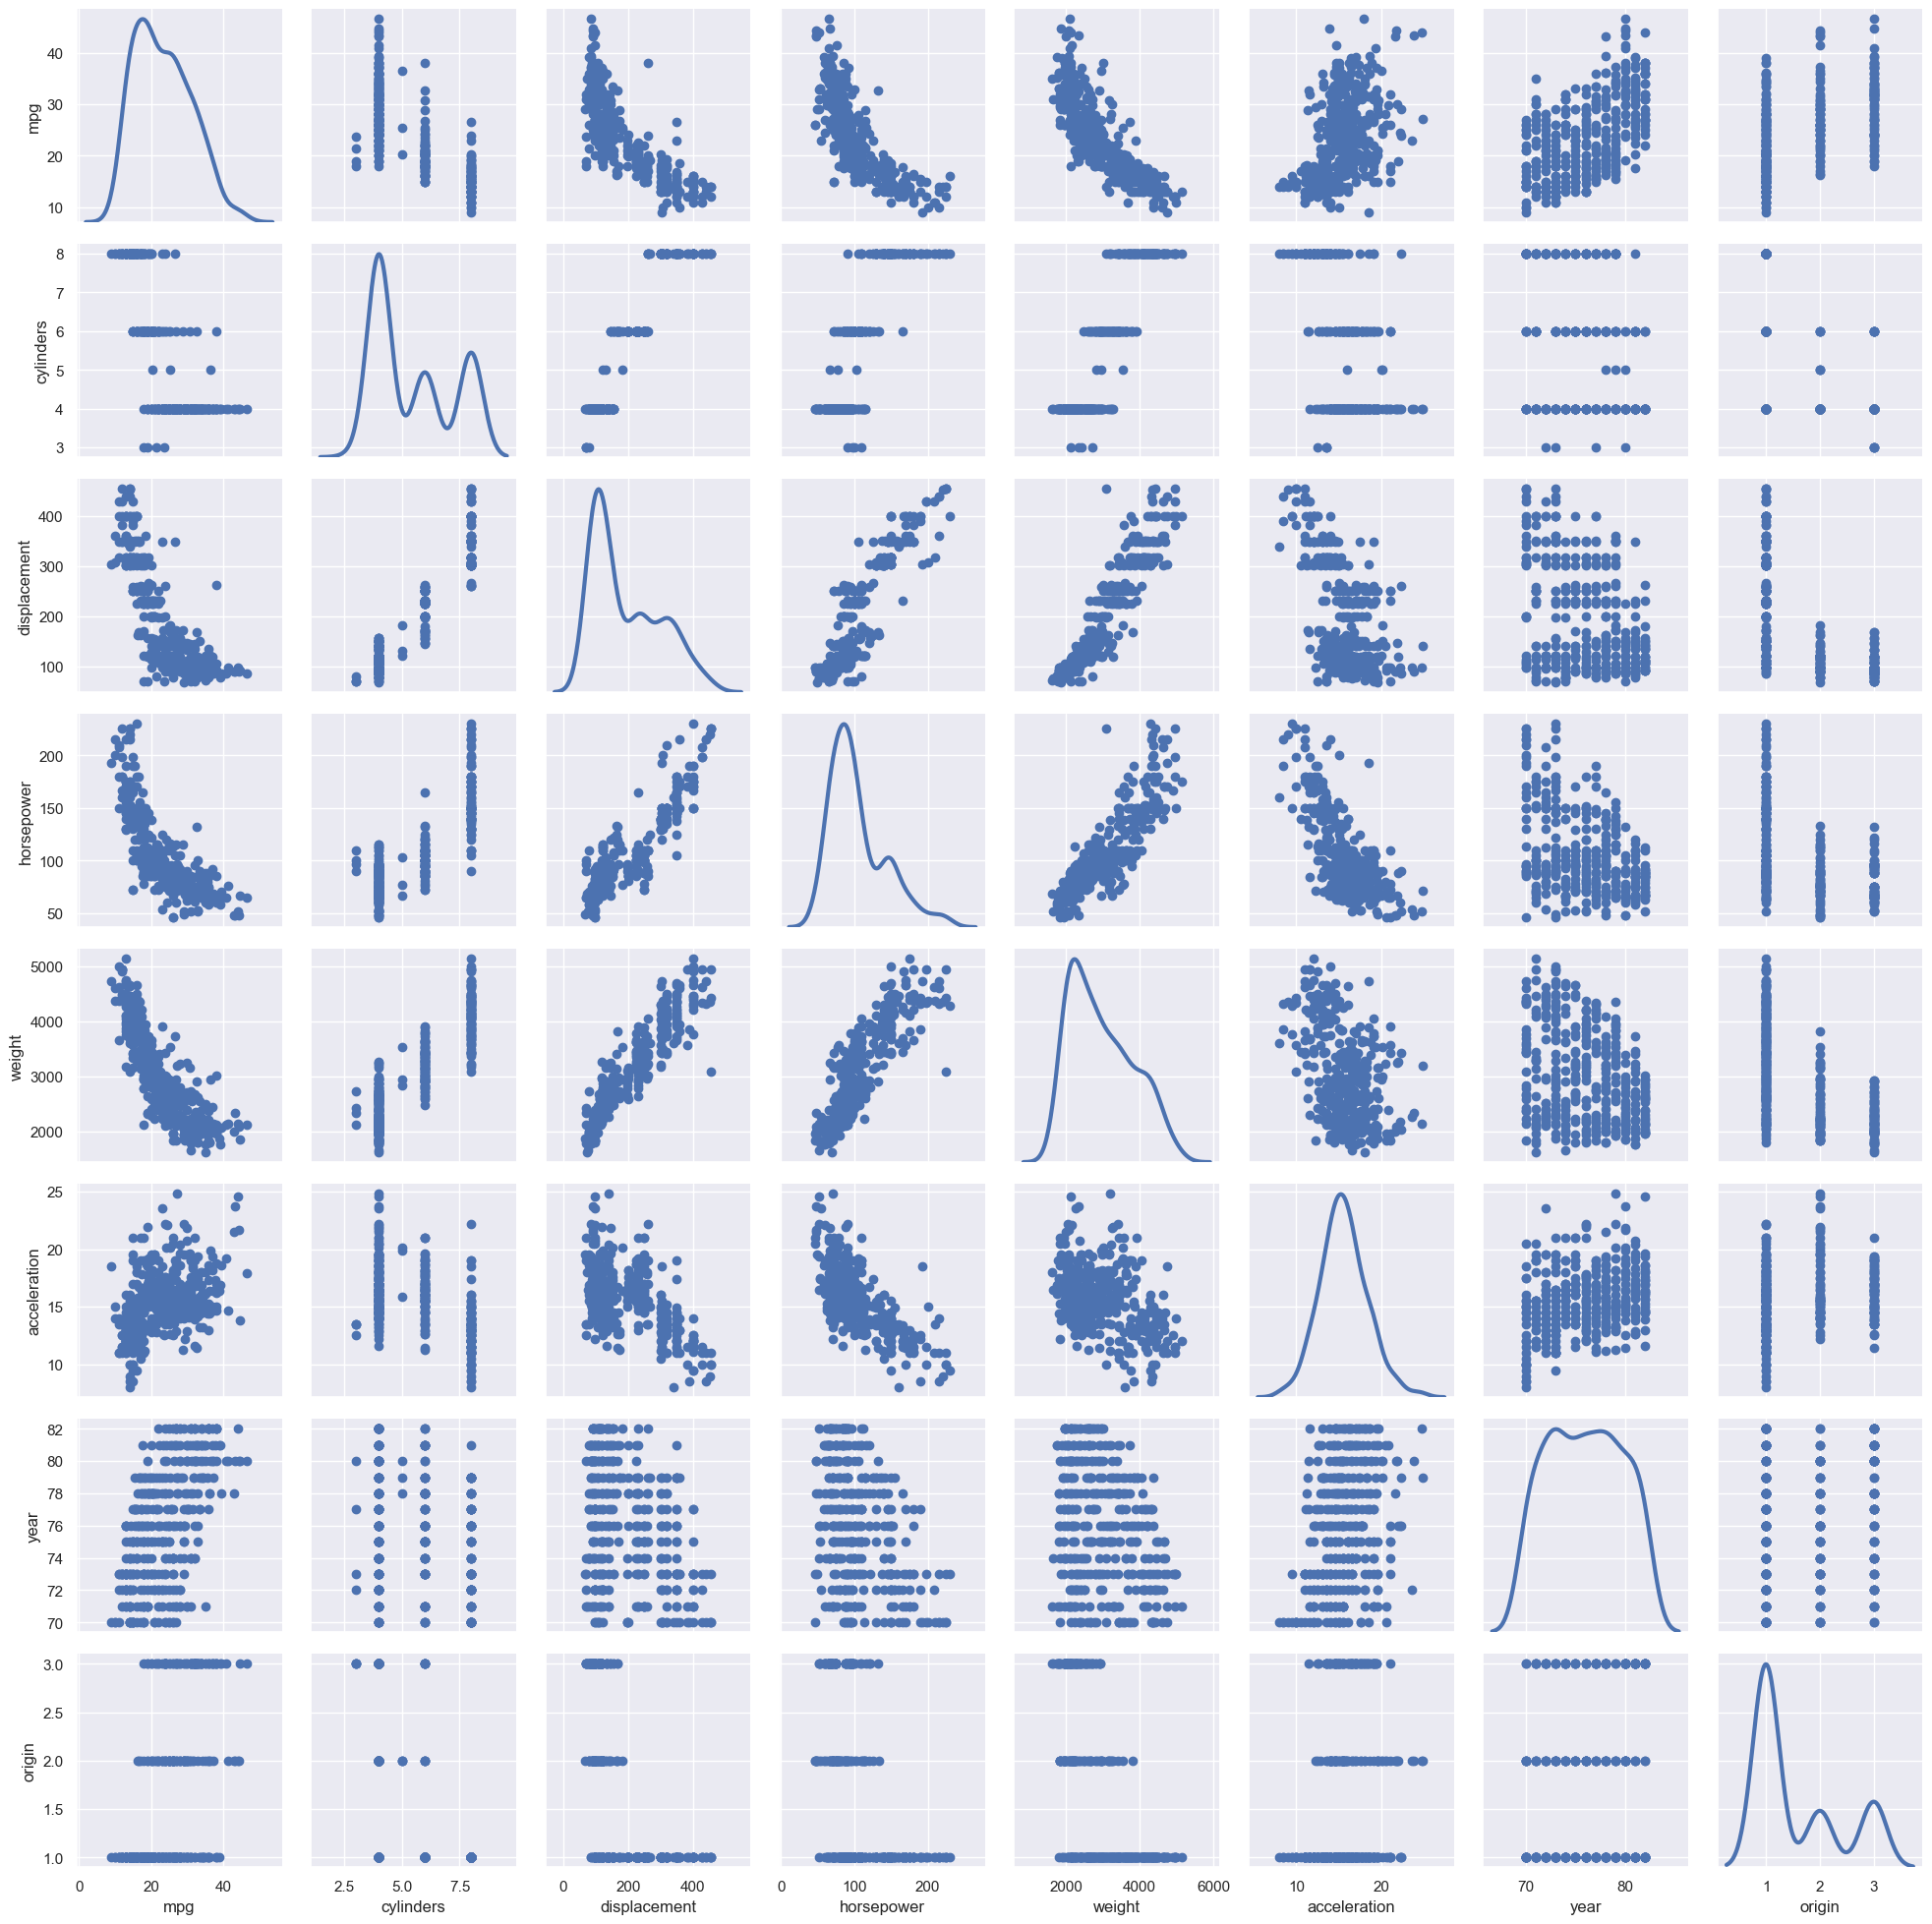

In [280]:
auto = load_data("Auto")
df = auto.reset_index()
pairplot = sns.PairGrid(auto, diag_sharey=False)
pairplot.map_lower(plt.scatter)
pairplot.map_upper(plt.scatter)
pairplot.map_diag(sns.kdeplot, lw=3, legend=False);

<h4>Part b)</h4>

In [78]:
auto.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


<h4>Part c)</h4>

In [283]:
X = auto[['cylinders','displacement','horsepower','weight','acceleration','year','origin']]
X = sm.add_constant(X) # add bias constant
y = auto['mpg']
results = sm.OLS(y, X).fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Thu, 19 Dec 2024   Prob (F-statistic):          2.04e-139
Time:                        14:00:15   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.2184      4.644     -3.707   

<h4>Part d)</h4>

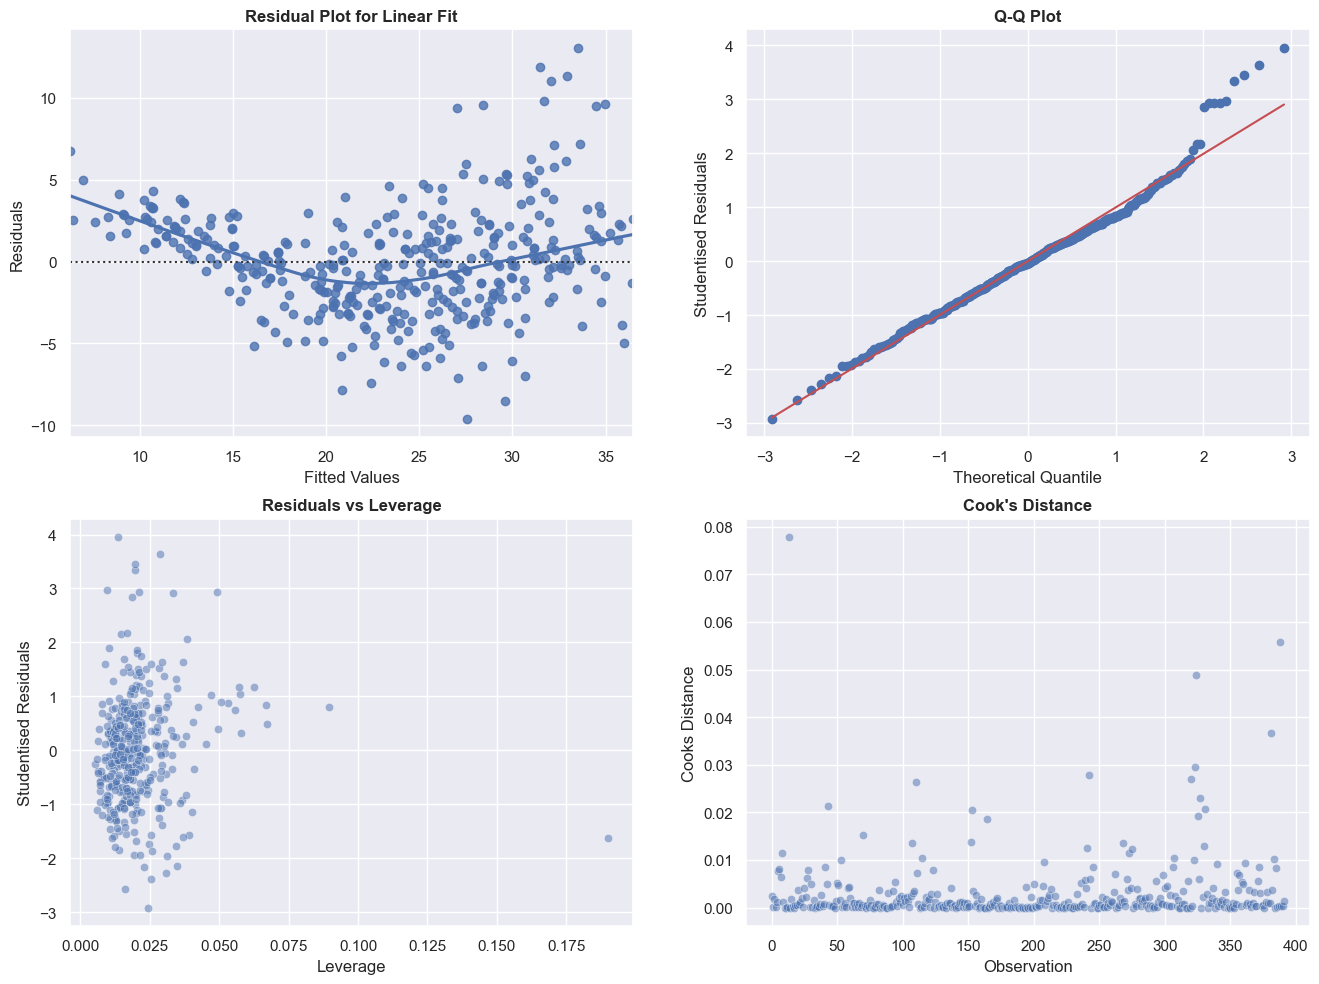

In [153]:
diagnostic_plots(x = ['cylinders','displacement','horsepower','weight','acceleration','year','origin'], y='mpg', df=auto)

In [167]:
#Highest leverage/residual outliers
cooks = results.get_influence().cooks_distance[0]
print('Observation with highest leverage:', np.where(cooks  == cooks.max())[0])
residuals = results.get_influence().resid_studentized_internal
print('Observation with largest residuals:', np.where(residuals >3)[0])

Observation with highest leverage: [13]
Observation with largest residuals: [242 320 323 324]


<h4>Part e) and f)</h4>

In [284]:
#Testing various interaction terms, looking at p-values can begin to remove variables through backward selection
model = 'mpg ~ displacement + horsepower + origin + weight + year \
               + displacement:cylinders + displacement:horsepower + displacement:origin + displacement:weight + displacement:year + displacement:acceleration\
               + horsepower:cylinders + horsepower:origin + horsepower:weight + horsepower:year + horsepower:acceleration \
               + origin:cylinders + origin:weight + origin:year + origin:acceleration \
               + weight:cylinders + weight:year + weight:acceleration'
results = smf.ols(model, auto).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     123.6
Date:                Thu, 19 Dec 2024   Prob (F-statistic):          1.48e-157
Time:                        14:00:33   Log-Likelihood:                -936.57
No. Observations:                 392   AIC:                             1921.
Df Residuals:                     368   BIC:                             2016.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [285]:
#Test various transformation of variables: horsepower, weight, origin, displacement
def square(row, variable):
    return np.square(row[variable])
    
def square_root(row, variable):
    return np.sqrt(row[variable])
    
def log(row, variable):
    return np.log(row[variable])
    
def var_parameters(variable):
    X = auto[['displacement','horsepower','weight','year','origin']]
    X = sm.add_constant(X) # add bias constant
    y = auto['mpg']
    X[variable+'_square'] = X.apply(square, variable=variable, axis=1)
    X[variable+'_log'] = X.apply(log, variable=variable, axis=1)
    X[variable+'_sqrt'] = X.apply(square_root, variable=variable, axis=1)
    results = sm.OLS(y, X).fit()
    print (results.summary())
    
#Change variable and see effect of transformations
var_parameters('displacement')

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     285.7
Date:                Thu, 19 Dec 2024   Prob (F-statistic):          2.73e-156
Time:                        14:00:39   Log-Likelihood:                -980.72
No. Observations:                 392   AIC:                             1979.
Df Residuals:                     383   BIC:                             2015.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -359.1748    

<h3>Question 10</h3>

<h4>Part a)</h4>

In [281]:
df = load_data("Carseats")
df['Urban'] = df['Urban'].map({'Yes':1, 'No':0})
df['US'] = df['US'].map({'Yes':1, 'No':0})
model = 'Sales ~ Price + Urban + US'
results = smf.ols(model, df).fit()
print(results.summary())
#High P value for urban indicates no statistical significance, for US (second qualitative variable) sales higher when US is True with 1200 more units. 
#Higher price, lower sales

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           2.39e-23
Time:                        13:59:27   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0435      0.651     20.036      0.0

<h4>Part c)</h4>
sales = 13.0435 + -0.0219*Urban + 1.2006*US -0.0545*Price

<h4>Part d)</h4>
Reject all null hypotheses except Urban

<h4>Part e)</h4>

In [289]:
model = 'Sales ~ Price + US'
results = smf.ols(model, df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           2.66e-24
Time:                        14:05:05   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0308      0.631     20.652      0.0

<h4>Part f)</h4>
Model1: R^2=0.239<br>Model2: R^2=0.239<br> Model 2 better because of fewer predictors

<h4>Part g)</h4>

In [290]:
results.conf_int(alpha=0.05)


,0,1
Intercept,11.79032,14.271265
US[T.1],0.69152,1.707766
Price,-0.06476,-0.044195


<h4>Part h)</h4>
No potential outliers according to studentised residuals (less than 3).\nSome relatively high leverage points to consider but well below cook's ditance threshold (1).\nNo outliers here.

Text(0.5, 1.0, 'Residuals vs Leverage')

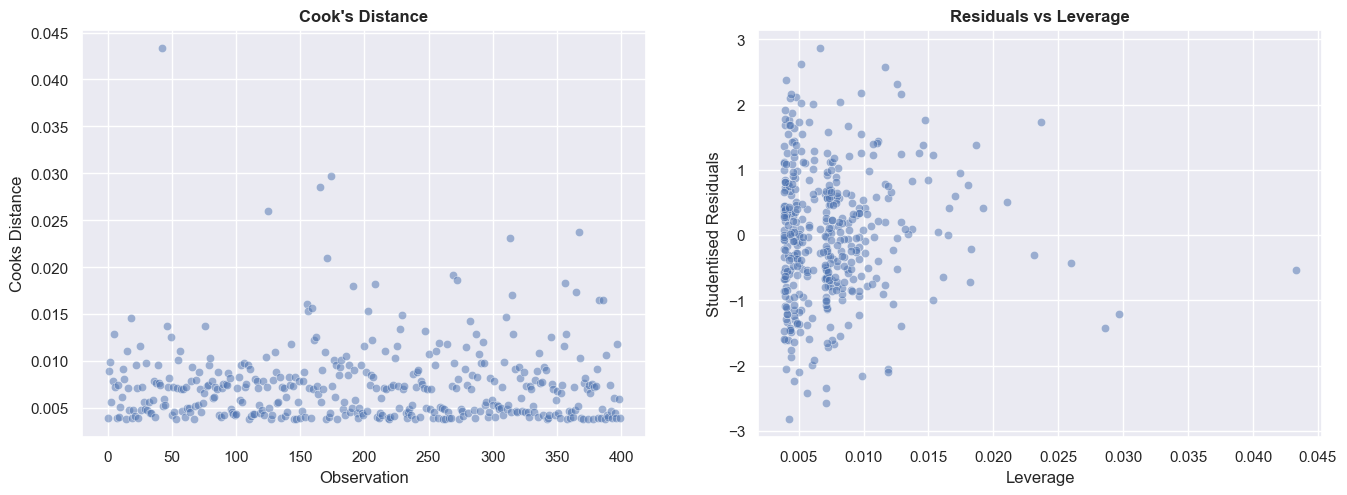

In [291]:
plt.figure(1, figsize=(16, 18))
plt.subplot(321)
hat_matrix = results.get_influence().hat_matrix_diag
observation = [i for i in range(len(influences))]
ax = sns.scatterplot(x=observation, y=hat_matrix, alpha=0.5)
plt.xlabel('Observation')
plt.ylabel('Cooks Distance')
plt.title('Cook\'s Distance', fontweight='bold')

plt.subplot(322)
normalized_residuals = results.get_influence().resid_studentized_internal
normalized_residuals_abs_sqrt = np.sqrt(np.abs(normalized_residuals))
ax = sns.scatterplot(x=hat_matrix, y=normalized_residuals, alpha=0.5)
plt.xlabel('Leverage')
plt.ylabel('Studentised Residuals')
plt.title('Residuals vs Leverage', fontweight='bold')

<h3>Question 11</h3>

<h4>Part a)</h4>
Coefficient of 1.9726, reject null hypothesis with p-value close to 0

<Axes: >

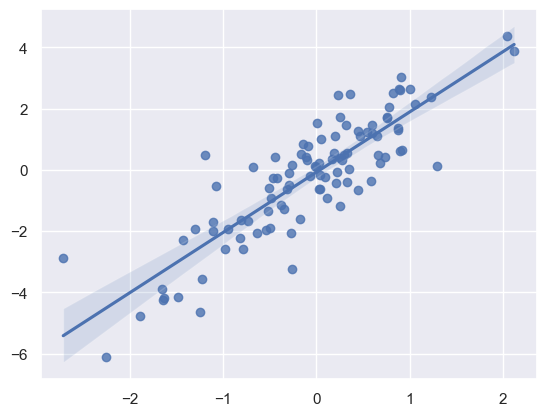

In [293]:
np.random.seed(1) 
rng = np.random.default_rng (1)
x = rng.normal(size =100)
y = 2 * x + rng.normal(size =100)
df = pd.DataFrame({'y':y, 'x':x})
fig, ax = plt.subplots()
sns.regplot(x=x, y=y, ax=ax)

In [294]:
model = 'y ~ x + 0'
results = smf.ols(model, df).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.743
Model:                            OLS   Adj. R-squared (uncentered):              0.740
Method:                 Least Squares   F-statistic:                              285.6
Date:                Thu, 19 Dec 2024   Prob (F-statistic):                    6.23e-31
Time:                        14:08:04   Log-Likelihood:                         -141.35
No. Observations:                 100   AIC:                                      284.7
Df Residuals:                      99   BIC:                                      287.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<h4>Part b)</h4>
Coefficient of 0.3757, reject null hypothesis with p-value clsoe to 0

In [295]:
reg = smf.ols('x ~ y + 0', df).fit()
print(reg.summary())

                                 OLS Regression Results                                
Dep. Variable:                      x   R-squared (uncentered):                   0.743
Model:                            OLS   Adj. R-squared (uncentered):              0.740
Method:                 Least Squares   F-statistic:                              285.6
Date:                Thu, 19 Dec 2024   Prob (F-statistic):                    6.23e-31
Time:                        14:08:28   Log-Likelihood:                         -58.349
No. Observations:                 100   AIC:                                      118.7
Df Residuals:                      99   BIC:                                      121.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<h4>Part c)</h4>
R-squared value and t-statistic the same. We'd expect the coefficients to be the inverse of each other but they aren't, the loss functions we're minimizing are different

<h4>Part d)</h4>
$\sum_{i=1}^{n} (y_i - x_i \beta)^2 = \sum_{i=1}^{n} (y_i^2 - 2 x_i \beta + x_i^2 \beta^2) = \sum_{i=1}^{n} y_i^2 - 2 \beta\sum_{i=1}^{n} x_i + \beta^2 \sum_{i=1}^{n} x_i^2 $
    
<br>
<br>
Where,<br>
    
$\hat{\beta} = \frac{\sum_{i=1}^{n} x_i y_i}{\sum_{i=1}^{n} x_i^2 }$

$\sum_{i=1}^{n}(y_i-x_i\hat{\beta}) = \sum_{i=1}^{n}(y_i)^2 - \frac{(\sum_{i=1}^{n} x_i y_i)^2}{\sum_{i=1}^{n} x_i^2 }$

and

$\frac{\hat{\beta}}{SE(\hat{\beta})}= \frac{(\sum_{i=1}^{n} x_i y_i) \sqrt{n-1} \sqrt{\sum_{i=1}^{n} x_i^2} }{ ( \sum_{i=1}^{n} x_i^2 ) \sqrt{\sum_{i=1}^{n} (y_i - x_i \beta)^2}} $

Substituting in $ \hat{\beta}$ and $\sum_{i=1}^{n}(y_i-x_i\hat{\beta})$, we find

$ \frac{(\sum_{i=1}^{n} x_i y_i) \sqrt{n-1} }{ \sqrt{ (\sum_{i=1}^{n} x_i^2 ) \left( \sum_{i=1}^{n} y_i^2 - \frac{(\sum_{i=1}^{n} x_i y_i)^2}{\sum_{i=1}^{n} x_i^2 } \right)}} = \frac{ (\sqrt{n-1} ) \sum_{i=1}^{n} x_i y_i }{ \sqrt{ (\sum_{i=1}^{n} x_i^2 )( \sum_{i=1}^{n} y_i^2 ) - (\sum_{i=1}^{n} x_i y_i)^2 } } $

<h4>Part e)</h4>
t-statistic is the same regardless of whether we regress on x or y

<h4>Part f)</h4>

In [267]:
X = df['x']
X = sm.add_constant(X) 
y = df['y']
results_yonx = sm.OLS(y, X).fit()

y = df['y']
y = sm.add_constant(y) 
x = df['x']
results_xony = sm.OLS(x, y).fit()
print('t-statistic of regressing y on x')
print(results_yonx.tvalues)

print('t-statistic of regressing x on y')
print(results_xony.tvalues)

t-statistic of regressing y on x
const    -0.756096
x        16.734055
dtype: float64
t-statistic of regressing x on y
const     0.216082
y        16.734055
dtype: float64


<h3>Question 12</h3>

<h4> Part a)</h4>

Looking at the coefficient estimate for simple linear regression without an intercept of y onto x and x onto y <br>
$ RSS_x = (y_i-\hat{\beta}_{x}x_i)^2 $ and $ RSS_y = (x_i-\hat{\beta}_{y}y_i)^2$<br>
Differentiationg with respect to $\hat{\beta}_{x}$ and $\hat{\beta}_{y}$ results in <br>
$\hat{\beta}_{x} = \frac{\sum_{i=1}^{n} x_i y_i}{\sum_{i=1}^{n} x_i^2 }$
$\hat{\beta}_{y} = \frac{\sum_{i=1}^{n} x_i y_i}{\sum_{i=1}^{n} y_i^2 }$<br>
Therefore, $\hat{\beta}_{x}$ and $\hat{\beta}_{y}$ are the same if $\sum_{i=1}^{n} x_i^2 $ = ${\sum_{i=1}^{n} y_i^2 }$

<h4>Part b)</h4>

In [301]:
x = np.arange(100)
y = x + np.random.normal(size=100)
df = pd.DataFrame({'x':x, 'y':y})

X = df['x']
y = df['y']
results1 = sm.OLS(y, X).fit()
results2 = sm.OLS(X, y).fit()
print('Beta_x = ', results1.params['x'])
print('Beta_y = ', results2.params['y'])

Beta_x =  1.0005299422264358
Beta_y =  0.9991636047975373


<h4>Part c)</h4>

In [304]:
#Need sum of x_i and sum of y_i to be the same, lets set x = y but randomize y 
x = np.arange(100)
y = np.random.permutation(x)
df = pd.DataFrame({'x':x, 'y':y})
X = df['x']
y = df['y']
results1 = sm.OLS(y, X).fit()
results2 = sm.OLS(X, y).fit()
print('Beta_x = ', results1.params['x'])
print('Beta_y = ', results2.params['y'])

Beta_x =  0.7336987970153801
Beta_y =  0.73369879701538


<h3>Question 13</h3>

<h4>Part a)</h4>

In [14]:
np.random.seed(1)
x = np.random.normal(loc=0, scale=1, size=100)

<h4>Part b)</h4>

In [15]:
eps = np.random.normal(loc=0, scale=0.25, size=100)

<h4>Part c)</h4>

In [16]:
y = -1.0+0.5*x+eps
print('B_0 = -1')
print('B_1= 0.5')
print('Length of vector y:', np.linalg.norm(y))

B_0 = -1
B_1= 0.5
Length of vector y: 10.660986158906173


<h4>Part d)</h4>

Text(0.5, 1.0, 'Normalized Data and EPS')

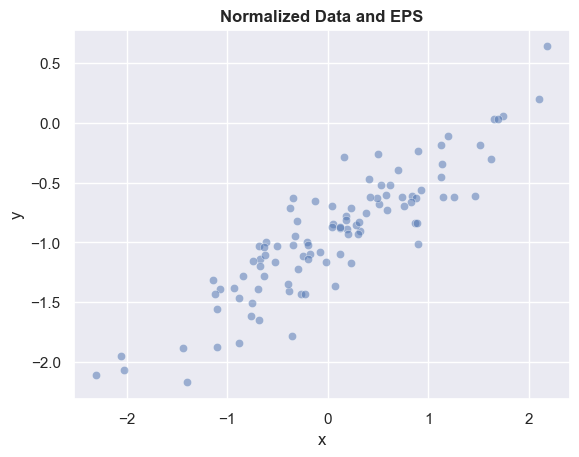

In [19]:
ax = sns.scatterplot(x=x, y=y, alpha=0.5)
ax.plot(x, results.fittedvalues, color='maroon')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Normalized Data and EPS', fontweight='bold')

<h4>Part e)</h4>

In [22]:
X = sm.add_constant(x)
results = sm.OLS(y, X).fit()
predictions = results.predict(X)
print("Predictions are very close to true values of -1, 0.5")
print(results.summary())

Predictions are very close to true values of -1, 0.5
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     391.4
Date:                Fri, 03 Jan 2025   Prob (F-statistic):           5.39e-36
Time:                        12:53:39   Log-Likelihood:                 4.1908
No. Observations:                 100   AIC:                            -4.382
Df Residuals:                      98   BIC:                            0.8288
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

<h4>Part f)</h4>

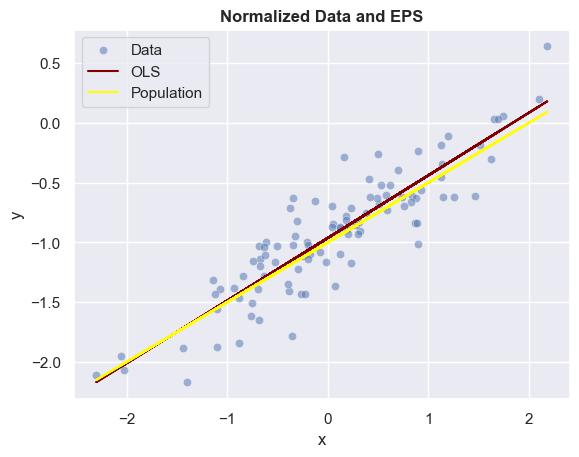

In [34]:
ax = sns.scatterplot(x=x, y=y, alpha=0.5)
ax.plot(x, results.fittedvalues, color='maroon')
ax.plot(x, -1+0.5*x, color='yellow')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Normalized Data and EPS', fontweight='bold')
ax.legend(['Data', 'OLS', 'Population'])


<h4>Part g)</h4>


In [50]:
x_2 = np.square(x)
X = np.vstack((x, x_2)).T
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
predictions = results.predict(X)
print("X^2 doesn't seem to affect the results")
print(results.summary())

X^2 doesn't seem to affect the results
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     193.8
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           1.32e-34
Time:                        15:04:48   Log-Likelihood:                 4.2077
No. Observations:                 100   AIC:                            -2.415
Df Residuals:                      97   BIC:                             5.400
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

<h4>Part h), i), j)</h4>

In [62]:
x = np.random.normal(loc=0, scale=1, size=100)

eps = np.random.normal(loc=0, scale=0.25, size=100)
y = -1.0+0.5*x+eps
X = sm.add_constant(x)
results = sm.OLS(y, X).fit()
print('Confidence Interval Normal Noise')
print(results.conf_int(alpha = 0.05))

eps_less = np.random.normal(loc=0, scale=0.05, size=100)
y = -1.0+0.5*x+eps_less
X = sm.add_constant(x)
results = sm.OLS(y, X).fit()
print('Confidence Interval Less Noise')
print(results.conf_int(alpha = 0.05))

eps_more = np.random.normal(loc=0, scale=0.5, size=100)
y = -1.0+0.5*x+eps_more
X = sm.add_constant(x)
results = sm.OLS(y, X).fit()
print('Confidence Interval More Noise')
print(results.conf_int(alpha = 0.05))

Confidence Interval Normal Noise
[[-1.02950658 -0.92338729]
 [ 0.44872609  0.54616484]]
Confidence Interval Less Noise
[[-1.0170209  -0.99501893]
 [ 0.49812013  0.51832234]]
Confidence Interval More Noise
[[-1.03894376 -0.8311846 ]
 [ 0.41375511  0.60451958]]


<h3> Question 14</h3>

<h4>Part a)</h4>

In [120]:
rng = np.random.default_rng(10)
x1 = rng.uniform(0, 1, size=100)
x2 = 0.5 * x1 + rng.normal(size=100) / 10
y = 2 + 2 * x1 + 0.3 * x2 + rng.normal(size=100)
print('Linear model with coefficients of B_0 =2, B_1=2, B_2=0.3')

Linear model with coefficients of B_0 =2, B_1=2, B_2=0.3


<h4>Part b)</h4>

Correlation of: 0.772324497691354


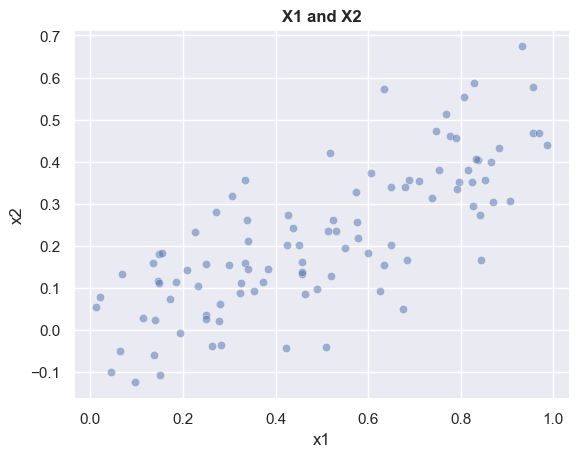

In [121]:
ax = sns.scatterplot(x=x1, y=x2, alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('X1 and X2', fontweight='bold')
print('Correlation of:', np.corrcoef(x1,x2)[0][1])

<h4>Part c)</h4>

In [122]:
x = np.vstack((x1, x2)).T
X = sm.add_constant(x)
results = sm.OLS(y, X).fit()
predictions = results.predict(X)

In [123]:
print(results.summary())
print('True Coefficients: B_0=2, B_1=2, B_2=0.3')
print('Predicted Coefficients B_0=1.9579, B_1=1.6154, B_2=0.9428')
print('Cannot reject null hypothesis for B_2')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     19.89
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           5.76e-08
Time:                        20:53:24   Log-Likelihood:                -130.62
No. Observations:                 100   AIC:                             267.2
Df Residuals:                      97   BIC:                             275.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9579      0.190     10.319      0.0

<h4>Part d)</h4>

In [124]:
X = sm.add_constant(x1)
results = sm.OLS(y, X).fit()
predictions = results.predict(X)
print(results.summary())
print('Can reject null hypothesis for B_1')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     38.39
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           1.37e-08
Time:                        20:53:25   Log-Likelihood:                -131.28
No. Observations:                 100   AIC:                             266.6
Df Residuals:                      98   BIC:                             271.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9371      0.189     10.242      0.0

<h4>Part e)</h4>

In [125]:
X = sm.add_constant(x2)
results = sm.OLS(y, X).fit()
predictions = results.predict(X)
print(results.summary())
print('Can reject null hypothesis for B_2')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     27.99
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           7.43e-07
Time:                        20:53:26   Log-Likelihood:                -135.24
No. Observations:                 100   AIC:                             274.5
Df Residuals:                      98   BIC:                             279.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3239      0.154     15.124      0.0

<h4>Part f)</h4>

In [126]:
print('Results contradict each other. When both x1 and x2 included in model, B_2 shows statistical insignificance with a p-value>0.05. However, with models that use only one of x1 or x2 both coefficients are statistically significant with p-values < 0.05')
print('Since x1 and x2 are highly correlated, the standard error increases for one of the coefficients because are variables are not independent.')

Results contradict each other. When both x1 and x2 included in model, B_2 shows statistical insignificance with a p-value>0.05. However, with models that use only one of x1 or x2 both coefficients are statistically significant with p-values < 0.05
Since x1 and x2 are highly correlated, the standard error increases for one of the coefficients because are variables are not independent.


<h4>Part g)</h4>

In [127]:
x1 = np.concatenate([x1, [0.1]]) 
x2 = np.concatenate([x2, [0.8]]) 
y = np.concatenate([y, [6]])
x = np.vstack((x1, x2)).T
X = sm.add_constant(x)
results = sm.OLS(y, X).fit()
predictions = results.predict(X)
print(results.summary())
print('True Coefficients: B_0=2, B_1=2, B_2=0.3')
print('Predicted Coefficients B_0=2.0618, B_1=0.8575, B_2=2.2663')
print('Cannot reject null hypothesis for B_1')
print('The addition of the miscalculated values makes the predictions of the coefficients for B_1 and B_2 more inaccurate')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     20.17
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           4.60e-08
Time:                        20:53:28   Log-Likelihood:                -135.30
No. Observations:                 101   AIC:                             276.6
Df Residuals:                      98   BIC:                             284.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0618      0.192     10.720      0.0

Anomaly is high leverage and has a big effect on the model


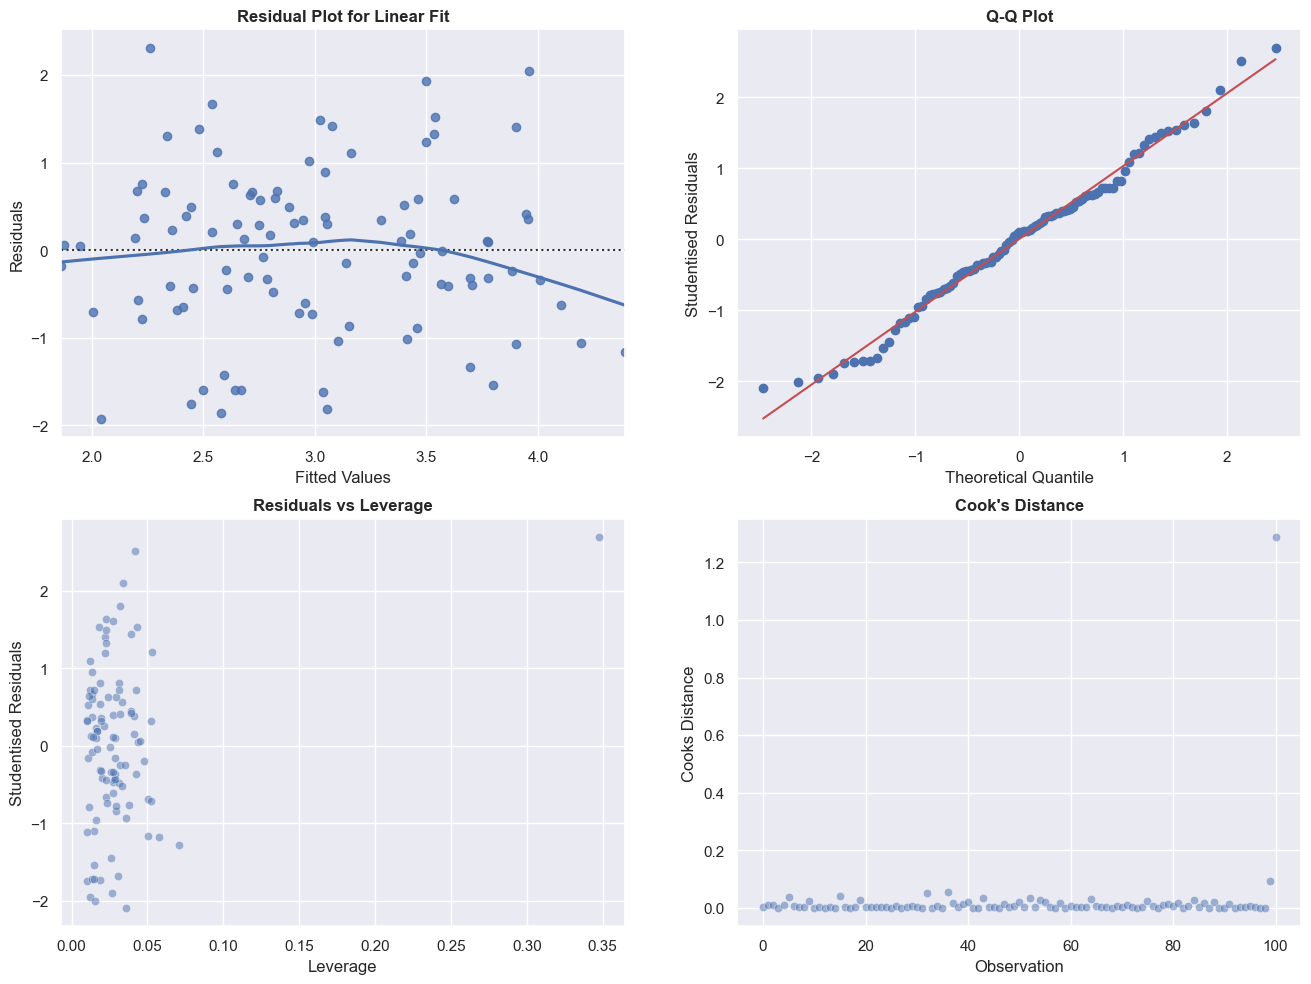

In [131]:
df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
diagnostic_plots(x=['x1', 'x2'], y='y', df=df)
print('Anomaly is high leverage and has a big effect on the model')